In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from koala.pointsets import uniform
from koala import graph_utils as gu
from koala import plotting as pl
from koala.voronization import generate_lattice
from koala.graph_color import color_lattice
from koala.flux_finder import fluxes_from_ujk, ujk_from_fluxes
from koala.lattice import Lattice
from scipy import linalg as la
from pfapack.pfaffian import pfaffian

from koala import example_graphs as eg
from dimer_models.koala_plantri import plantri_to_koala, plantri_generator, read_plantri
from dimer_models.lattice_generation import (
    bipartite_squarefull,
    reduce_bipartite,
)

from dimer_models.kasteleyn import kasteleyn_matrix, find_kasteleyn_number

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from copy import copy

In [20]:
# gu.remove_vertices()


def bipartition(lattice):

    bp = gu.distance_matrix(lattice)[0] % 2

    edge_colours = np.sum(bp[lattice.edges.indices], axis=1)

    if not np.all(edge_colours == 1):
        raise Exception("Lattice is not bipartite")

    return bp

In [21]:
cut_boundaries = False
import pickle

ns = 5000
with open(f"monomer_results/lattices/closed/02000/2.pkl", "rb") as f:
    lat_square = pickle.load(f)
    lat_reduced = pickle.load(f)
lattice = lat_reduced

In [33]:
dimerisations = gu.dimerise(lattice, 10)
dimer = dimerisations[-1]

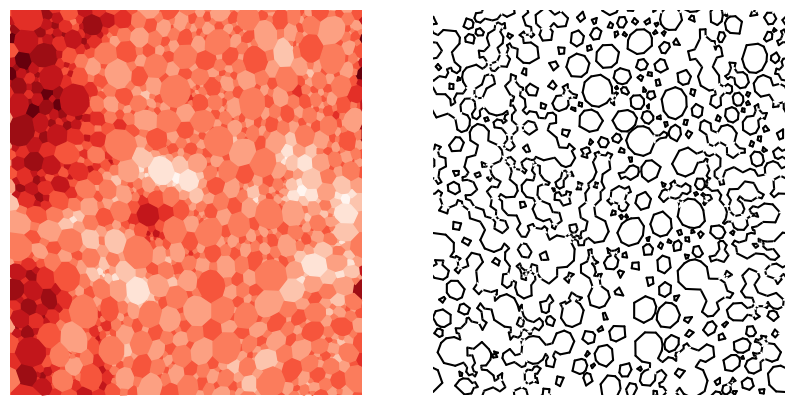

In [ ]:
bipart = bipartition(lattice)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# pl.plot_vertices(lattice, labels=bipart, color_scheme=["b", "r"], ax=ax[0])


directions = 1 - 2 * bipart[lattice.edges.indices][:, 0]
dual = gu.make_dual(lattice, reg_steps=0)

# check that each dual plaquette has the right swirling
for i, p in enumerate(dual.plaquettes):
    pols = directions[p.edges] * p.directions
    assert np.all(pols == pols[0])

# check its regular
coordination = np.array([len(c) for c in lattice.vertices.adjacent_edges])
assert np.all(coordination == coordination[0])
coordination = coordination[0]

tree = gu.edge_spanning_tree(dual, cross_boundaries=False)
tree_edges = dual.edges.indices[tree]
tree_dirs = directions[tree]
tree_dimers = dimer[tree]

dimer_cost = coordination - 1
non_dimer_cost = -1

tree_height_diffs = tree_dirs * (
    dimer_cost * (tree_dimers) + non_dimer_cost * (1 - tree_dimers)
)

heights = np.full(lattice.n_plaquettes, None)
heights[0] = 0


while np.any(heights == None):
    heights_assigned = heights != None

    assign_index_in_tree = np.where(np.sum(heights_assigned[tree_edges], axis=1) % 2)
    assignable_edges = tree_edges[assign_index_in_tree]
    ass_tree_height_diffs = tree_height_diffs[assign_index_in_tree]

    edge_signs = -1 + 2 * np.argwhere(heights_assigned[assignable_edges])[:, 1]

    vertices_to_assign = assignable_edges[
        np.where(1 - heights_assigned[assignable_edges])
    ]
    where_we_came_from = assignable_edges[np.where(heights_assigned[assignable_edges])]

    heights[vertices_to_assign] = (
        heights[where_we_came_from] + ass_tree_height_diffs * edge_signs
    )

heights = heights - np.min(heights)


positions = np.array([p.center for p in lattice.plaquettes])
# for i, txt in enumerate(heights):
#     ax[0].annotate(txt, (positions[i, 0], positions[i, 1]),ha='center',va='center')

pl.plot_edges(
    lattice,
    labels=dimer,
    ax=ax[1],
    color_scheme=["k", "w"],
)

# plort tree
# pl.plot_edges(
#     dual,
#     subset = tree,
#     ax=ax[0],
#     # alpha = 0.1
# )

# pl.plot_edges(
#     dual,
#     labels=dimer,
#     ax=ax[1],
#     color_scheme=["k", "g"],
#     linewidth=2,
#     directions=directions,
# )

cmap = mpl.colormaps["YlOrRd"]
cmap = mpl.colormaps["Reds"]
colours = cmap(np.linspace(0, 1, np.max([heights.astype("int")]) + 1))

pl.plot_plaquettes(
    lattice,
    heights,
    colours,
    ax=ax[0],
)

for a in ax:
    a.set_axis_off()

plt.savefig("heights.pdf", transparent=True)
plt.show()